In [1]:
import pandas as pd
import numpy as np
import sqlite3
import json
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
from os.path import expanduser
%matplotlib inline

In [2]:
EXPERIMENT_NAME = 'P3856_YHE211'

#### prepare the TFD/E results

In [3]:
# load the results
# EXPERIMENT_DIR = '/media/data-4t-a/results-P3856_YHE211/2021-10-06-06-59-25/P3856_YHE211/'
EXPERIMENT_DIR = '{}/Downloads/experiments/results-P3856_YHE211/2021-10-06-06-59-25/P3856_YHE211'.format(expanduser('~'))
RESULTS_DB_NAME = '{}/summarised-results/results.sqlite'.format(EXPERIMENT_DIR)
db_conn = sqlite3.connect(RESULTS_DB_NAME)
results_yhe211_df = pd.read_sql_query("select * from sequences", db_conn)
db_conn.close()

In [4]:
# load the results
# EXPERIMENT_DIR = '/media/data-4t-a/results-P3856_YHE114/2021-10-08-00-38-18/P3856_YHE114/'
EXPERIMENT_DIR = '{}/Downloads/experiments/results-P3856_YHE114/2021-10-08-00-38-18/P3856_YHE114'.format(expanduser('~'))
RESULTS_DB_NAME = '{}/summarised-results/results.sqlite'.format(EXPERIMENT_DIR)
db_conn = sqlite3.connect(RESULTS_DB_NAME)
results_yhe114_df = pd.read_sql_query("select * from sequences", db_conn)
db_conn.close()

In [5]:
results_df = pd.concat([results_yhe211_df,results_yhe114_df], axis=0, sort=False, ignore_index=True)

In [6]:
len(results_df)

36946

In [7]:
# convert the identifications from JSON to Python objects
results_df['identifications_d'] = results_df.apply(lambda row: json.loads(row.identifications), axis=1)

In [8]:
def classify_protein(protein):
    result = 'UNKNOWN'
    if 'HUMAN' in protein.upper():
        result = 'Human'
    elif 'YEAST' in protein.upper():
        result = 'Yeast'
    elif 'ECOLI' in protein.upper():
        result = 'E. coli'
    return result

In [9]:
# separate some key metrics into separate columns
results_df['id_perc_q_value'] = results_df.apply(lambda row: row.identifications_d['perc_q_value'], axis=1)
results_df['id_count_all_runs'] = results_df.apply(lambda row: len(row.identifications_d['run_names']), axis=1)
results_df['id_count_human_only_runs'] = results_df.apply(lambda row: sum('YHE010' in s for s in row.identifications_d['run_names']), axis=1)
results_df['id_number_of_proteins'] = results_df.apply(lambda row: row.identifications_d['number_of_proteins'], axis=1)

In [10]:
results_df['id_protein'] = results_df.apply(lambda row: row.identifications_d['proteins'][0], axis=1)
results_df['id_species'] = results_df.apply(lambda row: classify_protein(row.id_protein), axis=1)

In [11]:
results_df.id_species.unique()

array(['Human', 'Yeast', 'E. coli'], dtype=object)

In [12]:
# remove the results that couldn't be extracted or were not classified as a target
results_df = results_df[results_df.extractions.notnull()].copy()

In [13]:
# convert from JSON to Python objects
results_df['extractions_l'] = results_df.apply(lambda row: json.loads(row.extractions), axis=1)

In [14]:
# separate some key metrics into separate columns
results_df['ext_count_all_runs'] = results_df.apply(lambda row: len(row.extractions_l), axis=1)
results_df['ext_count_human_only_runs'] = results_df.apply(lambda row: sum('YHE010' in s['run_name'] for s in row.extractions_l), axis=1)

In [15]:
results_df.sample(n=3)

,sequence,charge,identifications,extractions,identifications_d,id_perc_q_value,id_count_all_runs,id_count_human_only_runs,id_number_of_proteins,id_protein,id_species,extractions_l,ext_count_all_runs,ext_count_human_only_runs
8548,KGEQELEGLTDTTVPK,2,"{""perc_q_value"": 1.7703188e-05, ""run_names"": [...","[{""run_name"": ""P3856_YHE211_1_Slot1-1_1_5104"",...","{'perc_q_value': 1.7703188e-05, 'run_names': [...",0.000018,10,0,1,"sp|P0CX37|RS6A_YEAST,sp|P0CX38|RS6B_YEAST",Yeast,"[{'run_name': 'P3856_YHE211_1_Slot1-1_1_5104',...",10,0
33171,SSPNEQEGILEGNSGEMVR,2,"{""perc_q_value"": 0.00015849406, ""run_names"": [...","[{""run_name"": ""P3856_YHE114_1_Slot1-1_1_5115"",...","{'perc_q_value': 0.00015849406, 'run_names': [...",0.000158,2,0,1,sp|P28273|OPLA_YEAST,Yeast,"[{'run_name': 'P3856_YHE114_1_Slot1-1_1_5115',...",10,0
19951,APVSVSCGGESPLDGICLSESDK,2,"{""perc_q_value"": 0.00057780859, ""run_names"": [...","[{""run_name"": ""P3856_YHE114_1_Slot1-1_1_5115"",...","{'perc_q_value': 0.00057780859, 'run_names': [...",0.000578,1,0,1,sp|O75410|TACC1_HUMAN,Human,"[{'run_name': 'P3856_YHE114_1_Slot1-1_1_5115',...",10,0


In [16]:
results_df.iloc[0].identifications

'{"perc_q_value": 0.0096781832, "run_names": ["P3856_YHE211_10_Slot1-1_1_5113", "P3856_YHE211_2_Slot1-1_1_5105"], "number_of_runs": 2, "proteins": ["sp|Q12948|FOXC1_HUMAN"], "number_of_proteins": 1}'

In [17]:
# count the number of unique peptide identifications in each run
counts_d = {}
for row in results_df.itertuples():
    for run_name in row.identifications_d['run_names']:
        if run_name not in counts_d:
            counts_d[run_name] = 0
        counts_d[run_name] += 1

In [18]:
# sort the run names by group then run number within the group
sorted_counts_l = []
for k in sorted(list(counts_d.keys()), key=lambda x: ( x.split('_')[1], int(x.split('_')[2]) )):
    short_run_name = '_'.join(k.split('_Slot')[0].split('_')[1:])
    sorted_counts_l.append((short_run_name, counts_d[k]))
sorted_counts_df = pd.DataFrame(sorted_counts_l, columns=['run_name','count'])

#### prepare the MaxQuant results

In [19]:
# MQ_RESULTS_DIR = '{}'.format(expanduser('~'))
MQ_RESULTS_DIR = '{}/Downloads/experiments'.format(expanduser('~'))
mq_results_df = pd.read_csv('{}/MQ-analysis-of-P3856/combined/txt/evidence.txt'.format(MQ_RESULTS_DIR), sep='\\t', engine='python')

In [20]:
# remove decoys, which are indicated by a '+' in the Reverse column
mq_results_df = mq_results_df[pd.isna(mq_results_df.Reverse)]
# remove identifications with no intensity
mq_results_df = mq_results_df[(mq_results_df.Intensity > 0)]
# remove potential contaminants
mq_results_df = mq_results_df[pd.isna(mq_results_df['Potential contaminant'])]
# remove identifications with mass error more than +/- 5 ppm
mq_results_df = mq_results_df[np.abs(mq_results_df['Mass error [ppm]']) <= 5.0]
# add RT as seconds
mq_results_df['retention_time_secs'] = mq_results_df['Retention time']*60.0

In [21]:
# definition of uniqueness in MaxQuant output with MBR on
unique_peptide_key = ['Sequence','Modifications','Charge']

In [22]:
# count the number of unique peptide identifications in each run
mq_counts_d = {}
for group_name,group_df in mq_results_df.groupby(unique_peptide_key, as_index=False):
    df = group_df[(group_df.Type == 'TIMS-MULTI-MSMS')]
    for run_name in df['Raw file'].unique():
        if run_name not in mq_counts_d:
            mq_counts_d[run_name] = 0
        mq_counts_d[run_name] += 1

In [23]:
mq_sorted_counts_l = []
for k in sorted(mq_counts_d.keys()):
    short_run_name = '_'.join(k.split('_Slot')[0].split('_')[1:3])
    mq_sorted_counts_l.append((short_run_name, mq_counts_d[k]))
mq_sorted_counts_df = pd.DataFrame(mq_sorted_counts_l, columns=['run_name','count'])

#### prepare the MSFragger results

In [24]:
# use the Fragger analysis without MBR because there doesn't seem to be a way of distinguishing between identification and matching

# FRAGGER_RESULTS_DIR = '{}'.format(expanduser('~'))
FRAGGER_RESULTS_DIR = '{}/Downloads/experiments'.format(expanduser('~'))
fragger_results_df = pd.read_csv('{}/MSFragger-analysis-P3856/MSstats-without-MBR.csv'.format(FRAGGER_RESULTS_DIR), sep=',')


In [25]:
fragger_results_df = fragger_results_df[fragger_results_df.Intensity.notnull()]

In [26]:
fragger_results_df.sample(n=5)

,ProteinName,PeptideSequence,PrecursorCharge,FragmentIon,ProductCharge,IsotopeLabelType,Condition,BioReplicate,Run,Intensity
331109,sp|P51665|PSMD7_HUMAN,TNDQMVVVYLASLIR,3,NaN,NaN,L,YHE211,9,P3856_YHE211_9_Slot1-1_1_5112,6751.735
437607,sp|Q13451|FKBP5_HUMAN,RGEAQLLMNEFESAK,2,NaN,NaN,L,YHE211,7,P3856_YHE211_7_Slot1-1_1_5110,96561.690
478533,sp|Q16401|PSMD5_HUMAN,TIAEIFGNPNYLR,2,NaN,NaN,L,YHE010,3,P3856_YHE010_3_Slot1-1_1_5095,8743.112
503968,sp|Q6RFH5|WDR74_HUMAN,GLAQADGTLITC[57.0215]VDSGILR,2,NaN,NaN,L,YHE211,8,P3856_YHE211_8_Slot1-1_1_5111,46148.100
551131,sp|Q92841|DDX17_HUMAN,ELAQQVQQVADDYGK,2,NaN,NaN,L,YHE010,1,P3856_YHE010_1_Slot1-1_1_5093,40778.125


In [27]:
# count the number of unique peptide identifications in each run
fragger_counts_d = {}
for group_name,group_df in fragger_results_df.groupby(['PeptideSequence', 'PrecursorCharge'], as_index=False):
    for run_name in group_df['Run'].unique():
        if run_name not in fragger_counts_d:
            fragger_counts_d[run_name] = 0
        fragger_counts_d[run_name] += 1

In [28]:
# sort the run names by group then run number within the group
sorted_counts_l = []
for k in sorted(list(fragger_counts_d.keys()), key=lambda x: ( x.split('_')[1], int(x.split('_')[2]) )):
    short_run_name = '_'.join(k.split('_Slot')[0].split('_')[1:])
    sorted_counts_l.append((short_run_name, fragger_counts_d[k]))
fragger_sorted_counts_df = pd.DataFrame(sorted_counts_l, columns=['run_name','count'])

#### plot the unique peptide level

In [29]:
merged_df = sorted_counts_df.merge(mq_sorted_counts_df,on='run_name').merge(fragger_sorted_counts_df,on='run_name')
merged_df.rename({'count_x':'TFD/E', 'count_y':'MaxQuant', 'count':'MSFragger'}, axis=1, inplace=True)
merged_df.index = merged_df.run_name

In [30]:
merged_df.sample(n=3)

,run_name,TFD/E,MaxQuant,MSFragger
run_name,,,,
YHE211_5,YHE211_5,11902,10146,12836
YHE211_10,YHE211_10,10948,9285,11987
YHE114_7,YHE114_7,11178,9454,12288


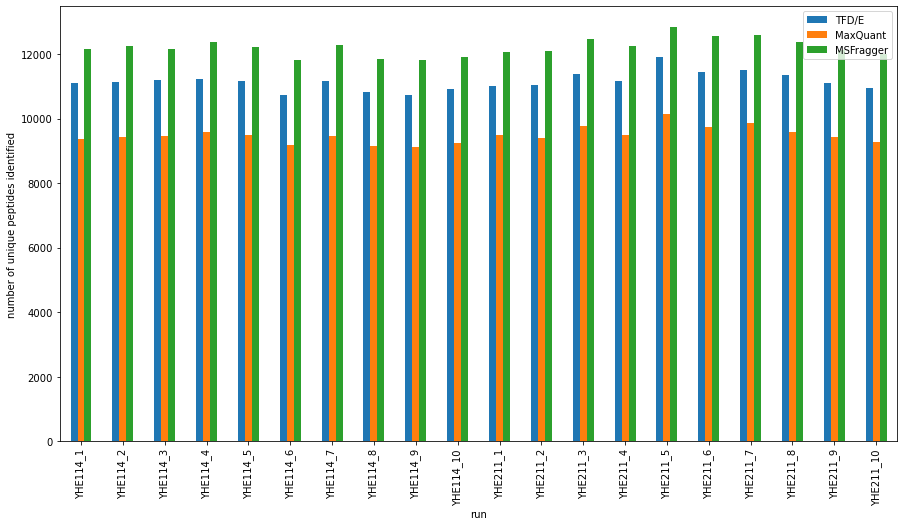

In [31]:
merged_df.plot(kind='bar', figsize=(15,8))
# _ = plt.title("Unique peptides identified in each run")
_ = plt.xlabel("run")
_ = plt.ylabel("number of unique peptides identified")

## missing-ness heatmaps

In [32]:
# return True if we can include an extraction from the specified group, given the groups in which it was identified
# need to implement these rules differently for each experiment, probably best with a simple rules parameter file
def extract_from_group(extract_group, identification_run_names_l):
    result = False
    identification_groups_l = list(set([r.split('_')[1] for r in identification_run_names_l]))
    if extract_group == 'YHE010':
        result = extract_group in identification_groups_l
    else:
        result = True
    return result

#### prepare the TFD/E data

In [33]:
# gather the lower intensity decile
results_df.columns

Index(['sequence', 'charge', 'identifications', 'extractions',
       'identifications_d', 'id_perc_q_value', 'id_count_all_runs',
       'id_count_human_only_runs', 'id_number_of_proteins', 'id_protein',
       'id_species', 'extractions_l', 'ext_count_all_runs',
       'ext_count_human_only_runs'],
      dtype='object')

In [34]:
sequences_l = []
for row in results_df.itertuples():
    for group_name in ['YHE114','YHE211','YHE010']:
        if extract_from_group(extract_group=group_name, identification_run_names_l=row.identifications_d['run_names']):
            for extraction in row.extractions_l:
                if group_name in extraction['run_name']:
                    short_run_name = '_'.join(extraction['run_name'].split('_Slot')[0].split('_')[1:3])
                    identified_in_run = extraction['run_name'] in row.identifications_d['run_names']
                    sequences_l.append((row.sequence, row.charge, row.id_perc_q_value, row.id_protein, row.id_species, short_run_name, group_name, extraction['intensity'], identified_in_run))
sequences_df = pd.DataFrame(sequences_l, columns=['sequence', 'charge', 'id_perc_q_value', 'protein', 'species', 'short_run_name', 'group','intensity','identified_in_run'])


In [35]:
sequences_df[sequences_df.species == 'E. coli'].sample(n=5)

,sequence,charge,id_perc_q_value,protein,species,short_run_name,group,intensity,identified_in_run
213358,ELANVQDLTVR,2,0.000252,sp|P02925|RBSB_ECOLI,E. coli,YHE114_2,YHE114,978,True
352037,YWHDTTVQMSDFK,2,0.000080,sp|P76108|YDCS_ECOLI,E. coli,YHE114_10,YHE114,688,False
255366,ISELSEGQIDTLRDEVAK,2,0.006899,sp|P0A7S9|RS13_ECOLI,E. coli,YHE114_1,YHE114,3118,False
252221,ILILHADHEQNASTSTVR,2,0.000015,sp|P0ABH7|CISY_ECOLI,E. coli,YHE114_1,YHE114,853,True
222011,FFVASDVHPQTLDVVR,2,0.000212,sp|P33195|GCSP_ECOLI,E. coli,YHE114_4,YHE114,969,True


In [36]:
# find the mean intensity for each peptide in each group
intensities_l = []
for group_name,group_df in sequences_df.groupby(['sequence','charge','group'], as_index=False):
    mean_intensity = group_df.intensity.mean()
    intensities_l.append((group_name[0], group_name[1], group_name[2], mean_intensity))
intensities_df = pd.DataFrame(intensities_l, columns=['sequence', 'charge', 'group', 'group_mean_intensity'])

In [37]:
# sort each group by descending intensity
intensities_df.sort_values(by=['group_mean_intensity'], ascending=False, inplace=True)

In [38]:
intensities_df.tail()

,sequence,charge,group,group_mean_intensity
29296,SYSPYDMLESIR,2,YHE211,90.6
26258,Q[-17.0265]VKPYVEEGLHPQIIIR,3,YHE211,88.4
4386,DIILSSTSAPPASAQPPLQLSEVNIPLSLGVCPLGPVPLTK,3,YHE211,75.0
30481,TLALLVLAHSSDVLENVFSSLTDDK,3,YHE211,71.0
19889,LQDVFNTVGADIIQLPQIVVVGTQSSGK,3,YHE211,59.5


In [39]:
# make a separate DF for each group
yhe010_df = intensities_df[(intensities_df.group == 'YHE010')].copy()
yhe114_df = intensities_df[(intensities_df.group == 'YHE114')].copy()
yhe211_df = intensities_df[(intensities_df.group == 'YHE211')].copy()

In [40]:
# find the lowest-intensity peptides in each group
lower_number = 500
yhe010_lowest_df = yhe010_df.tail(lower_number)
yhe114_lowest_df = yhe114_df.tail(lower_number)
yhe211_lowest_df = yhe211_df.tail(lower_number)

## TFD/E heatmaps

#### plot YHE211

In [41]:
run_names_l = sorted(list(sequences_df[sequences_df.group == 'YHE211'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [42]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe211_lowest_df.itertuples():
    run_occurences_df = sequences_df[(sequences_df.sequence == row.sequence) & (sequences_df.charge == row.charge) & (sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

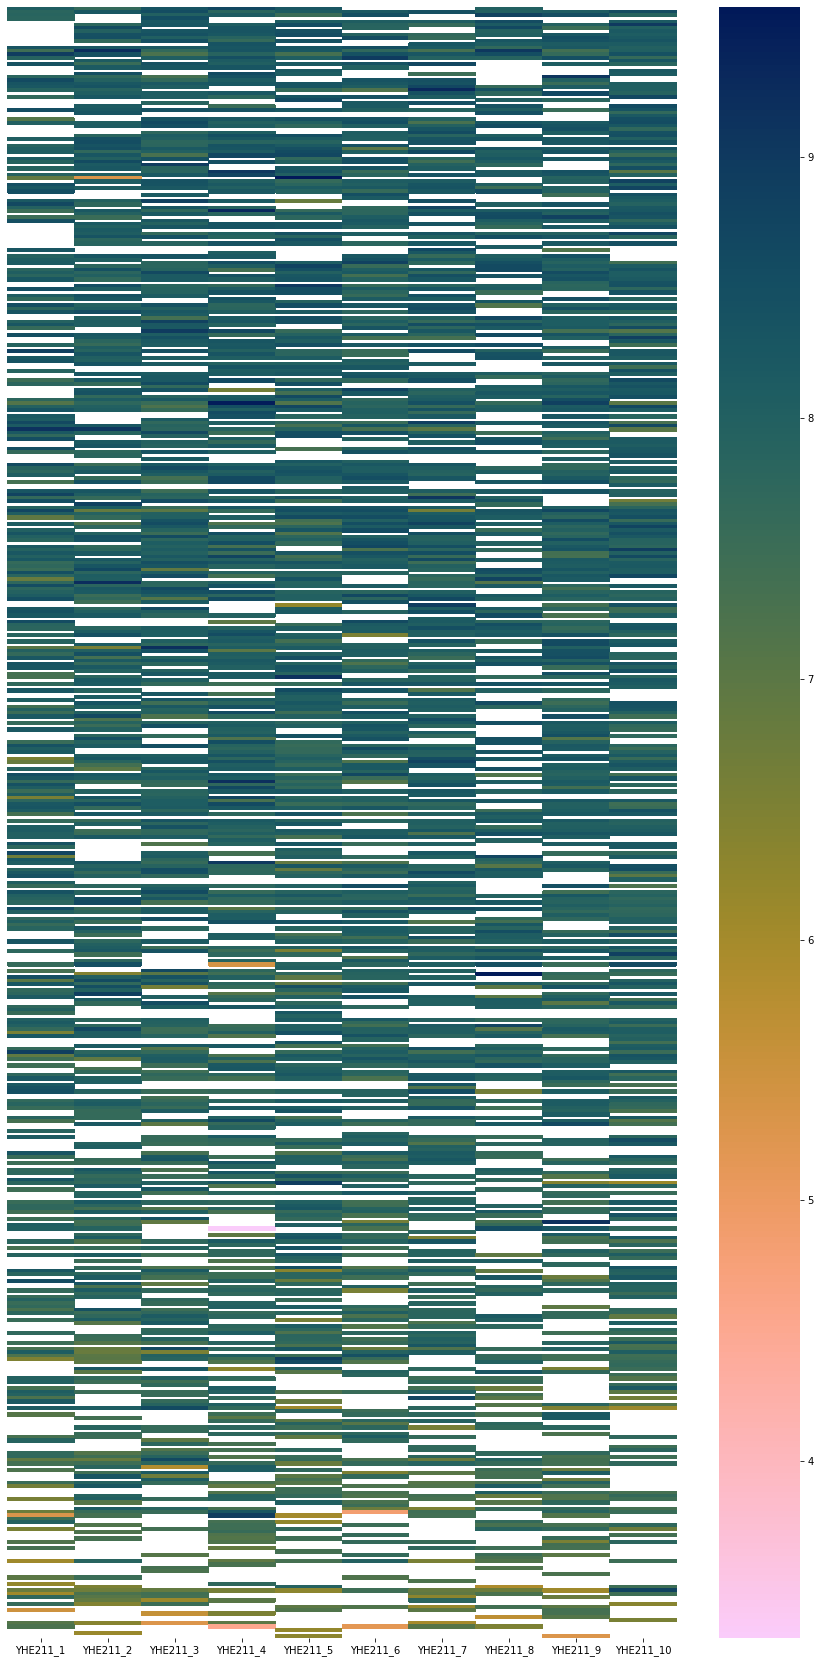

In [43]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap=cm.batlow_r, vmin=a[a > 0].min(), vmax=a.max(), mask=(occurences_df==0), linewidths=0)
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
# plt.title('Lowest {} peptides by mean intensity for YHE211 by TFD/E'.format(lower_number))

## MaxQuant heatmaps

In [44]:
mq_results_df.columns

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins', 'Leading proteins', 'Leading razor protein', 'Type',
       'Raw file', 'MS/MS m/z', 'Charge', 'm/z', 'Mass',
       'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Ion mobility index',
       'Ion mobility length', '1/K0', '1/K0 length', 'Calibrated 1/K0', 'CCS',
       'Calibrated CCS', 'CCS length', 'Match time difference',
       'Match m/z difference', 'Match K0 difference', 'Match q-value',
       'M

In [45]:
mq_results_df.iloc[1466].Proteins

'sp|P31040|SDHA_HUMAN'

In [46]:
# get one reading for each unique peptide in each run, and count how many identifications and extractions (i.e. 
# matches) across each group. Note that a sequence can be counted as an identification and a match in the same file 
# (i.e. it's given a different score).
mq_sequences_l = []
unique_peptide_key_file = unique_peptide_key + ['Raw file']
for group_name,group_df in mq_results_df.groupby(unique_peptide_key_file, as_index=False):
    identified_in_file = (len(group_df[group_df.Type == 'TIMS-MULTI-MSMS']) > 0)
    short_run_name = '_'.join(group_name[3].split('_Slot')[0].split('_')[1:3])
    grp_name = short_run_name.split('_')[0]
    sorted_df = group_df.sort_values(by=['Intensity'], ascending=False, inplace=False)
    if identified_in_file:
        score = sorted_df.iloc[0]['Score']
    else:
        score = sorted_df.iloc[0]['Match score']
    intensity = sorted_df.iloc[0].Intensity
    protein = sorted_df.iloc[0].Proteins
    species = classify_protein(protein)
    mq_sequences_l.append((group_name[0], group_name[1], group_name[2], species, short_run_name, grp_name, identified_in_file, score, intensity))
mq_sequences_df = pd.DataFrame(mq_sequences_l, columns=['sequence','modifications','charge','species','short_run_name','group','identified_in_file','score','intensity'])


In [47]:
mq_sequences_df.sample(n=5)

,sequence,modifications,charge,species,short_run_name,group,identified_in_file,score,intensity
391660,VWNVAENSYVETLFGHQDAVAALDALSR,Unmodified,3,Human,YHE114_10,YHE114,True,60.329,29765.0
166176,IHQIGPGMVQQIQSVCMECQGHGER,Unmodified,3,Human,YHE010_7,YHE010,True,39.480,93985.0
113264,FVLCPECENPETDLHVNPK,Unmodified,3,Human,YHE010_8,YHE010,True,61.042,57104.0
352074,TPVIDADKPVSSQLR,Unmodified,2,Human,YHE211_7,YHE211,True,123.920,79259.0
74078,EESQIPVDEVFFHR,Unmodified,2,Human,YHE010_1,YHE010,False,101.390,24264.0


In [48]:
# find the mean intensity for each peptide in each group
mq_intensities_l = []
for group_name,group_df in mq_sequences_df.groupby(['sequence','modifications','charge','group'], as_index=False):
    mean_intensity = group_df.intensity.mean()
    mq_intensities_l.append((group_name[0], group_name[1], group_name[2], group_name[3], mean_intensity))
mq_intensities_df = pd.DataFrame(mq_intensities_l, columns=['sequence', 'modifications', 'charge', 'group', 'group_mean_intensity'])

In [49]:
# sort each group by descending intensity
mq_intensities_df.sort_values(by=['group_mean_intensity'], ascending=False, inplace=True)

In [50]:
mq_intensities_df.tail()

,sequence,modifications,charge,group,group_mean_intensity
46385,VDNAYWLWTFQGR,Unmodified,2,YHE114,873.45
34372,NYLPLLEPVKPEPK,Unmodified,2,YHE211,869.28
8699,EATWTMSNITAGR,Unmodified,2,YHE010,756.94
3300,AQLAQDGVQLCALDDLDSK,Unmodified,2,YHE114,728.88
27256,LMAPYTPFLTELMYQNLK,Unmodified,2,YHE010,719.49


In [51]:
# make a separate DF for each group
yhe010_df = mq_intensities_df[(mq_intensities_df.group == 'YHE010')].copy()
yhe114_df = mq_intensities_df[(mq_intensities_df.group == 'YHE114')].copy()
yhe211_df = mq_intensities_df[(mq_intensities_df.group == 'YHE211')].copy()

In [52]:
# find the lowest-intensity peptides in each group
lower_number = 500
yhe010_lowest_df = yhe010_df.tail(lower_number)
yhe114_lowest_df = yhe114_df.tail(lower_number)
yhe211_lowest_df = yhe211_df.tail(lower_number)

#### plot YHE211

In [53]:
run_names_l = sorted(list(mq_sequences_df[mq_sequences_df.group == 'YHE211'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [54]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe211_lowest_df.itertuples():
    run_occurences_df = mq_sequences_df[(mq_sequences_df.sequence == row.sequence) & (mq_sequences_df.modifications == row.modifications) & (mq_sequences_df.charge == row.charge) & (mq_sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

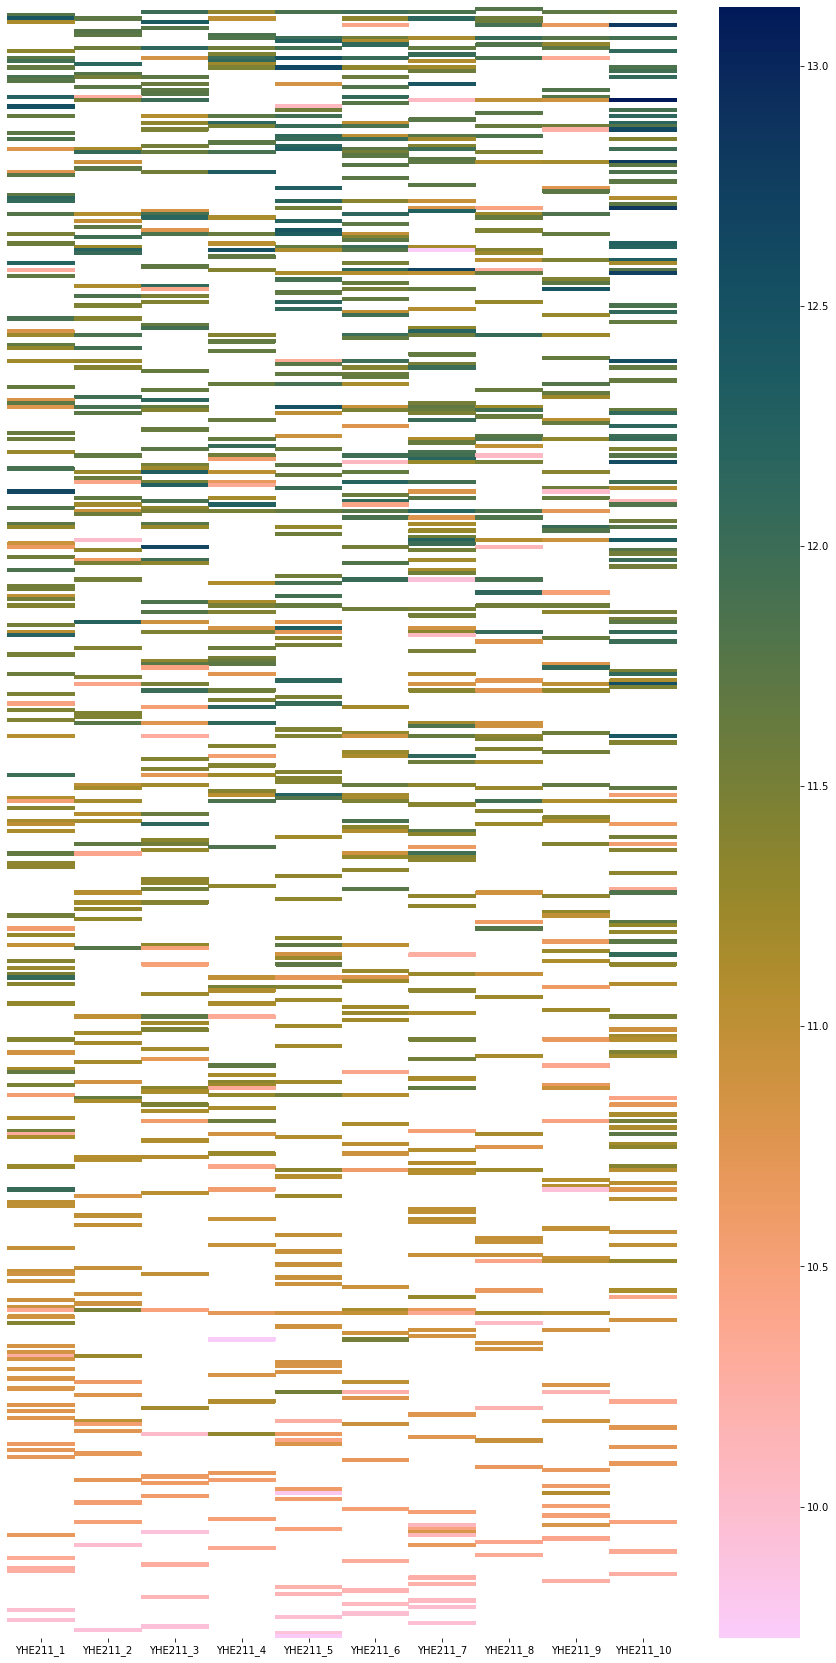

In [55]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap=cm.batlow_r, vmin=a[a > 0].min(), vmax=a.max(), mask=(occurences_df==0), linewidths=0)
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
# plt.title('Lowest {} peptides by mean intensity for YHE211 by MaxQuant'.format(lower_number))

## Fragger heatmaps

In [56]:
# use the analysis with MBR

# FRAGGER_RESULTS_DIR = '{}'.format(expanduser('~'))
FRAGGER_RESULTS_DIR = '{}/Downloads/experiments'.format(expanduser('~'))
fragger_results_df = pd.read_csv('{}/MSFragger-analysis-P3856/MSstats-P3856.csv'.format(FRAGGER_RESULTS_DIR), sep=',')

In [57]:
fragger_sequences_df = fragger_results_df.copy()
fragger_sequences_df.columns

Index(['ProteinName', 'PeptideSequence', 'PrecursorCharge', 'FragmentIon',
       'ProductCharge', 'IsotopeLabelType', 'Condition', 'BioReplicate', 'Run',
       'Intensity'],
      dtype='object')

In [58]:
fragger_sequences_df['short_run_name'] = fragger_sequences_df.apply(lambda row: '_'.join(row.Run.split('_Slot')[0].split('_')[1:3]), axis=1)

In [59]:
fragger_sequences_df['species'] = fragger_sequences_df.apply(lambda row: classify_protein(row.ProteinName), axis=1)

In [60]:
fragger_sequences_df = fragger_sequences_df[fragger_sequences_df.Intensity.notnull()]
fragger_sequences_df = fragger_sequences_df[fragger_sequences_df.Intensity > 0]

In [61]:
fragger_sequences_df.sample(n=3)

,ProteinName,PeptideSequence,PrecursorCharge,FragmentIon,ProductCharge,IsotopeLabelType,Condition,BioReplicate,Run,Intensity,short_run_name,species
308248,sp|P40037|HMF1_YEAST,VNNLIFLSGQIPVTPDNK,2,NaN,NaN,L,YHE211,8,P3856_YHE211_8_Slot1-1_1_5111,187735.830,YHE211_8,Yeast
334987,sp|P46940|IQGA1_HUMAN,SWVNQMESQTGEASK,2,NaN,NaN,L,YHE010,7,P3856_YHE010_7_Slot1-1_1_5099,15344.175,YHE010_7,Human
729615,sp|Q9UJX4|APC5_HUMAN,LNQLLLPLLQGPDITLSK,2,NaN,NaN,L,YHE114,5,P3856_YHE114_5_Slot1-1_1_5119,30986.656,YHE114_5,Human


In [62]:
# find the mean intensity for each peptide in each group
fragger_intensities_l = []
for group_name,group_df in fragger_sequences_df.groupby(['PeptideSequence','PrecursorCharge','Condition'], as_index=False):
    mean_intensity = group_df.Intensity.mean()
    fragger_intensities_l.append((group_name[0], group_name[1], group_name[2], mean_intensity))
fragger_intensities_df = pd.DataFrame(fragger_intensities_l, columns=['sequence', 'charge', 'group', 'group_mean_intensity'])

In [63]:
# sort each group by descending intensity
fragger_intensities_df.sort_values(by=['group_mean_intensity'], ascending=False, inplace=True)

In [64]:
fragger_intensities_df.tail()

,sequence,charge,group,group_mean_intensity
48241,VC[57.0215]NYVNWIQQTIAAN,2,YHE211,357.09050
43509,STSSETDC[57.0215]NDNVPSHK,2,YHE114,324.62850
39256,RDLPNALDEK,2,YHE010,290.59800
14658,FNLSVIEDPSMK,2,YHE211,247.62599
137,AAGALLNGPPQFSTAPEIK,2,YHE010,214.77450


In [65]:
# make a separate DF for each group
yhe010_df = fragger_intensities_df[(fragger_intensities_df.group == 'YHE010')].copy()
yhe114_df = fragger_intensities_df[(fragger_intensities_df.group == 'YHE114')].copy()
yhe211_df = fragger_intensities_df[(fragger_intensities_df.group == 'YHE211')].copy()

In [66]:
# find the lowest-intensity peptides in each group
lower_number = 500
yhe010_lowest_df = yhe010_df.tail(lower_number)
yhe114_lowest_df = yhe114_df.tail(lower_number)
yhe211_lowest_df = yhe211_df.tail(lower_number)

#### plot YHE211

In [67]:
run_names_l = sorted(list(fragger_sequences_df[fragger_sequences_df.Condition == 'YHE211'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [68]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe211_lowest_df.itertuples():
    run_occurences_df = fragger_sequences_df[(fragger_sequences_df.PeptideSequence == row.sequence) & (fragger_sequences_df.PrecursorCharge == row.charge) & (fragger_sequences_df.Condition == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.Intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

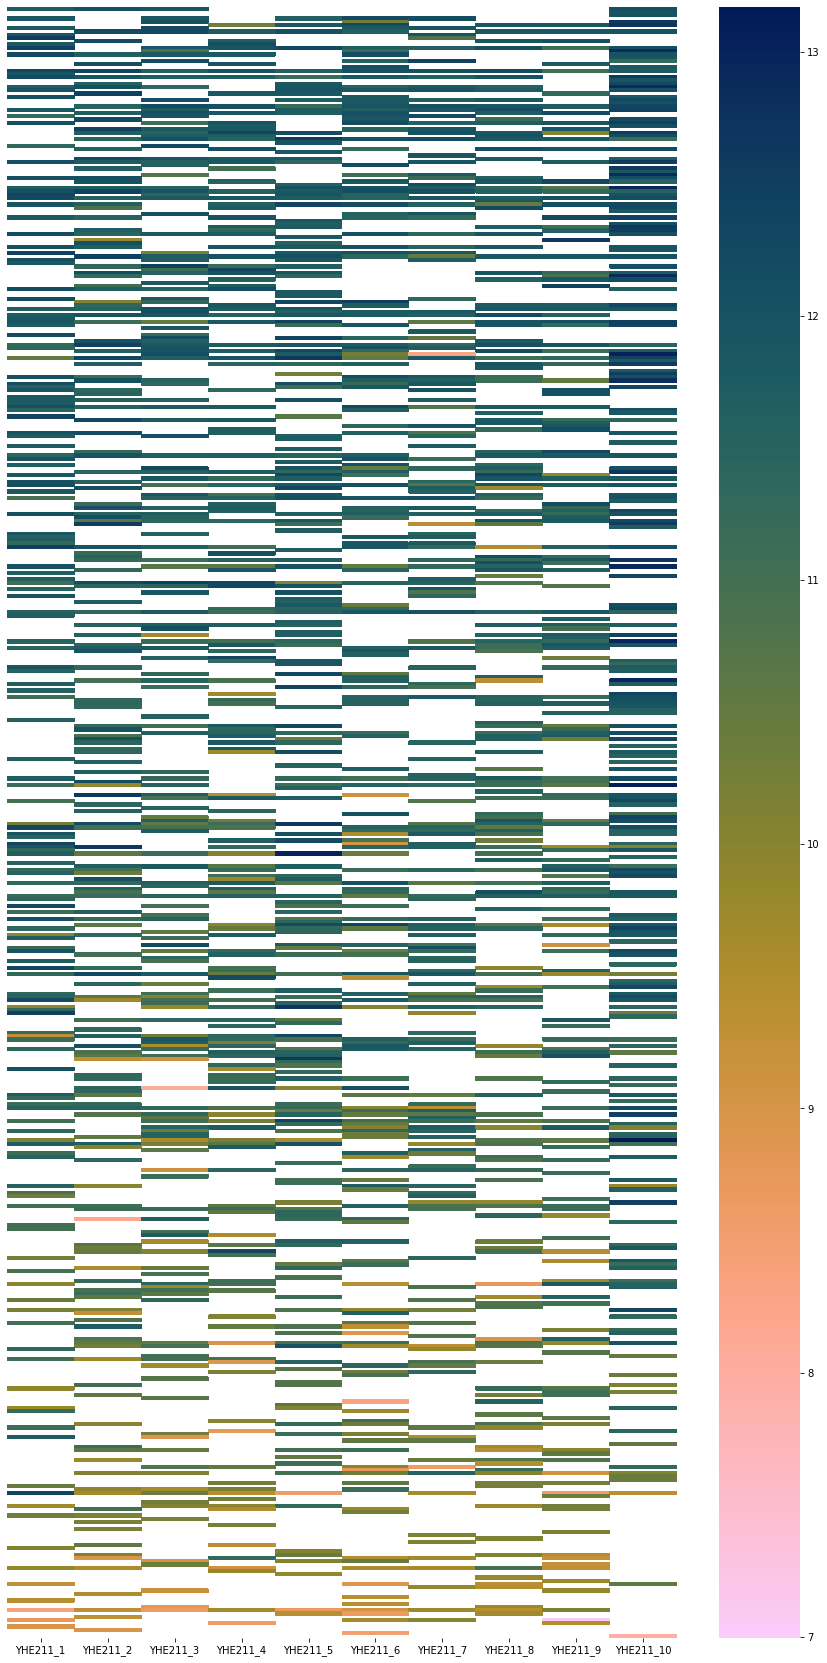

In [69]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap=cm.batlow_r, vmin=a[a > 0].min(), vmax=a.max(), mask=(occurences_df==0), linewidths=0)
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
# plt.title('Lowest {} peptides by mean intensity for YHE211 by MSFragger'.format(lower_number))

## visualise the percentage of missing values across runs

#### prepare TFD/E results

In [70]:
subset_groups = ['YHE211']

In [71]:
tfde_subset_df = sequences_df[(sequences_df.group.isin(subset_groups))]

In [72]:
number_of_runs_in_subset = len(tfde_subset_df.short_run_name.unique())
print('there are {} {} runs in the experiment'.format(number_of_runs_in_subset, subset_groups))

there are 10 ['YHE211'] runs in the experiment


In [73]:
number_of_unique_sequences_tfde = len(tfde_subset_df.drop_duplicates(subset=['sequence', 'charge'], keep='first', inplace=False))
number_of_unique_sequences_tfde

18695

In [74]:
# count how many runs each sequence/charge was extracted from and classified as a target
sequence_occurences_l = []
for group_name,group_df in tfde_subset_df.groupby(['sequence','charge'], as_index=False):
    sequence_occurences_l.append((group_name, len(group_df.short_run_name.unique()), group_name[0], group_name[1]))
tfde_sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['sequence_charge','number_of_runs_extracted','sequence','charge'])

In [75]:
tfde_sequence_occurences_df['missing_files'] = number_of_runs_in_subset - tfde_sequence_occurences_df.number_of_runs_extracted

In [76]:
# display the number of missing values across the subset
tfde_missing_values = tfde_sequence_occurences_df.missing_files.sum() / (len(tfde_sequence_occurences_df) * number_of_runs_in_subset)

In [77]:
tfde_sequence_occurences_df.sample(n=3)

,sequence_charge,number_of_runs_extracted,sequence,charge,missing_files
1585,"(CLEIYDMIGQAISSSR, 2)",10,CLEIYDMIGQAISSSR,2,0
17937,"(WYQMGIVSWGEGCDR, 2)",10,WYQMGIVSWGEGCDR,2,0
5153,"(FVTDLLLHFIK, 2)",10,FVTDLLLHFIK,2,0


In [78]:
run_count_l = []
for number_of_runs in range(1,number_of_runs_in_subset+1):
    run_count_l.append((number_of_runs, len(tfde_sequence_occurences_df[tfde_sequence_occurences_df.number_of_runs_extracted >= number_of_runs])))
tfde_run_count_df = pd.DataFrame(run_count_l, columns=['run_count','number_of_sequences'])

In [79]:
tfde_run_count_df['percent_quantified'] = tfde_run_count_df.number_of_sequences / number_of_unique_sequences_tfde * 100

#### prepare MQ results

In [80]:
mq_sequences_df.columns

Index(['sequence', 'modifications', 'charge', 'species', 'short_run_name',
       'group', 'identified_in_file', 'score', 'intensity'],
      dtype='object')

In [81]:
mq_subset_df = mq_sequences_df[(mq_sequences_df.group.isin(subset_groups))]

In [82]:
number_of_unique_sequences_mq = len(mq_subset_df.drop_duplicates(subset=['sequence','modifications','charge'], keep='first', inplace=False))
number_of_unique_sequences_mq

18336

In [83]:
# count how many runs each sequence/charge was extracted from
sequence_occurences_l = []
for group_name,group_df in mq_subset_df.groupby(['sequence', 'modifications', 'charge'], as_index=False):
    sequence_occurences_l.append((group_name[0], group_name[1], group_name[2], len(group_df.short_run_name.unique())))
mq_sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['sequence','modifications','charge','number_of_runs_extracted'])

In [84]:
run_count_l = []
for number_of_runs in range(1,number_of_runs_in_subset+1):
    run_count_l.append((number_of_runs, len(mq_sequence_occurences_df[mq_sequence_occurences_df.number_of_runs_extracted >= number_of_runs])))
mq_run_count_df = pd.DataFrame(run_count_l, columns=['run_count','number_of_sequences'])

In [85]:
mq_sequence_occurences_df['missing_files'] = number_of_runs_in_subset - mq_sequence_occurences_df.number_of_runs_extracted
mq_run_count_df['percent_quantified'] = mq_run_count_df.number_of_sequences / number_of_unique_sequences_mq * 100

In [86]:
# display the number of missing values across the subset
mq_missing_values = mq_sequence_occurences_df.missing_files.sum() / (len(mq_sequence_occurences_df) * number_of_runs_in_subset)

#### prepare Fragger results

In [87]:
fragger_subset_df = fragger_sequences_df[(fragger_sequences_df.Condition.isin(subset_groups))]

In [88]:
number_of_unique_sequences_fragger = len(fragger_subset_df.drop_duplicates(subset=['PeptideSequence', 'PrecursorCharge'], keep='first', inplace=False))
number_of_unique_sequences_fragger

19351

In [89]:
# count how many runs each sequence/charge was found in
sequence_occurences_l = []
for group_name,group_df in fragger_subset_df.groupby(['PeptideSequence','PrecursorCharge'], as_index=False):
    sequence_occurences_l.append((group_name[0], group_name[1], len(group_df.short_run_name.unique())))
fragger_sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['sequence','charge','number_of_runs_extracted'])

In [90]:
run_count_l = []
for number_of_runs in range(1,number_of_runs_in_subset+1):
    run_count_l.append((number_of_runs, len(fragger_sequence_occurences_df[fragger_sequence_occurences_df.number_of_runs_extracted >= number_of_runs])))
fragger_run_count_df = pd.DataFrame(run_count_l, columns=['run_count','number_of_sequences'])

In [91]:
fragger_sequence_occurences_df['missing_files'] = number_of_runs_in_subset - fragger_sequence_occurences_df.number_of_runs_extracted
fragger_run_count_df['percent_quantified'] = fragger_run_count_df.number_of_sequences / number_of_unique_sequences_fragger * 100

In [92]:
# display the number of missing values across the subset
fragger_missing_values = fragger_sequence_occurences_df.missing_files.sum() / (len(fragger_sequence_occurences_df) * number_of_runs_in_subset)

#### now plot the results

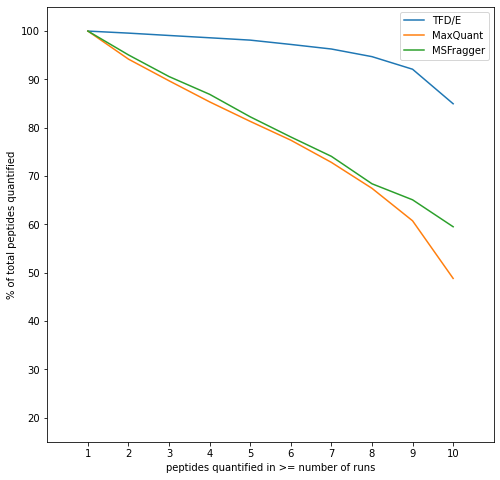

In [93]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(8)

plt.margins(0.06)
# plt.title('percentage of peptides without missing values as a function of run numbers for conditions {}'.format(subset_groups))

ax1.plot(tfde_run_count_df.run_count, tfde_run_count_df.percent_quantified, label='TFD/E')
ax1.plot(mq_run_count_df.run_count, mq_run_count_df.percent_quantified, label='MaxQuant')
ax1.plot(fragger_run_count_df.run_count, fragger_run_count_df.percent_quantified, label='MSFragger')

plt.xlabel('peptides quantified in >= number of runs')
plt.ylabel('% of total peptides quantified')
plt.ylim((15,105))
ax1.set(xticks=range(1,number_of_runs_in_subset+1), xlim=[0, number_of_runs_in_subset+1])
plt.legend(loc="best")

plt.show()

## missing-ness distributions

#### plot TFD/E results

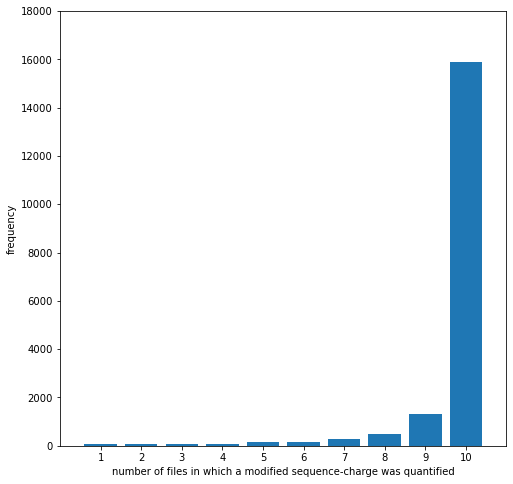

In [94]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(8)

plt.margins(0.06)
# plt.suptitle('TFD/E distribution of sequence identifications for conditions {}'.format(subset_groups))
# plt.title('total of {} modified peptide sequences, {}% of values missing'.format(number_of_unique_sequences_tfde, int(round(tfde_missing_values*100))))

counts = np.bincount(tfde_sequence_occurences_df.number_of_runs_extracted)
ax1.bar(range(number_of_runs_in_subset+1), counts, width=0.8, align='center')
plt.xlabel('number of files in which a modified sequence-charge was quantified')
plt.ylabel('frequency')
ax1.set(xticks=range(1,number_of_runs_in_subset+1), xlim=[0, number_of_runs_in_subset+1])
plt.ylim((0,18000))

plt.show()

#### plot MQ results

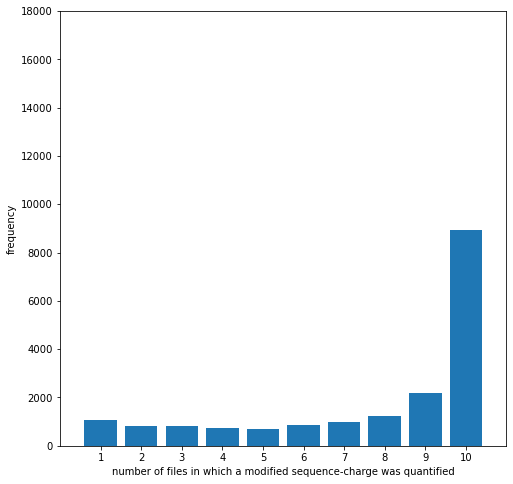

In [95]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(8)

plt.margins(0.06)
# plt.suptitle('MaxQuant distribution of sequence identifications for conditions {}'.format(subset_groups))
# plt.title('total of {} modified peptide sequences, {}% of values missing'.format(number_of_unique_sequences_mq, int(round(mq_missing_values*100))))

counts = np.bincount(mq_sequence_occurences_df.number_of_runs_extracted)
ax1.bar(range(number_of_runs_in_subset+1), counts, width=0.8, align='center')
plt.xlabel('number of files in which a modified sequence-charge was quantified')
plt.ylabel('frequency')
ax1.set(xticks=range(1,number_of_runs_in_subset+1), xlim=[0, number_of_runs_in_subset+1])
plt.ylim((0,18000))

plt.show()

#### plot Fragger results

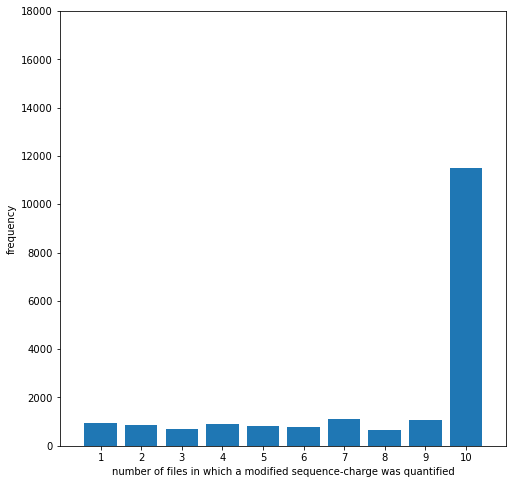

In [96]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(8)

plt.margins(0.06)
# plt.suptitle('MSFragger distribution of sequence identifications for conditions {}'.format(subset_groups))
# plt.title('total of {} modified peptide sequences, {}% of values missing'.format(number_of_unique_sequences_fragger, int(round(fragger_missing_values*100))))

counts = np.bincount(fragger_sequence_occurences_df.number_of_runs_extracted)
ax1.bar(range(number_of_runs_in_subset+1), counts, width=0.8, align='center')
plt.xlabel('number of files in which a modified sequence-charge was quantified')
plt.ylabel('frequency')
ax1.set(xticks=range(1,number_of_runs_in_subset+1), xlim=[0, number_of_runs_in_subset+1])
plt.ylim((0,18000))

plt.show()

## distribution of quantitative intensities

#### prepare TFD/E results

In [97]:
tfde_subset_df.sample(n=3)

,sequence,charge,id_perc_q_value,protein,species,short_run_name,group,intensity,identified_in_run
20674,DHDGYYWIR,2,0.000154,sp|P52910|ACS2_YEAST,Yeast,YHE211_4,YHE211,472,True
73296,ILATLQGLEAVNAVLESTPDTPSPLIAVNENK,4,0.000347,sp|P16862|PFKA2_YEAST,Yeast,YHE211_10,YHE211,617,True
173413,YEEVSVSGFEEFHR,2,0.000018,sp|Q9BRA2|TXD17_HUMAN,Human,YHE211_1,YHE211,2462,True


In [98]:
# calculate the intensity mean for peptides without missing values
tfde_intensities_l = []
for group_name,group_df in tfde_subset_df.groupby(['sequence','charge'], as_index=False):
    if len(group_df.short_run_name.unique()) == number_of_runs_in_subset:
        intensity_mean = group_df.intensity.mean()
        tfde_intensities_l.append((','.join([group_name[0],group_name[1].astype('str')]),intensity_mean,'TFD/E'))
tfde_intensities_df = pd.DataFrame(tfde_intensities_l, columns=['sequence','intensity','method'])
tfde_intensities_df['intensity_adjusted'] = tfde_intensities_df.intensity - np.min(tfde_intensities_df.intensity)
tfde_intensities_df.intensity_adjusted.replace(to_replace=[0.0], value=1.0, inplace=True)

#### prepare MQ results

In [99]:
mq_subset_df.sample(n=3)

,sequence,modifications,charge,species,short_run_name,group,identified_in_file,score,intensity
273482,PETAQGQFLNFNK,Unmodified,2,Yeast,YHE211_7,YHE211,True,29.755,189380.0
190655,LASEEPPDDEEALATIR,Unmodified,2,Human,YHE211_9,YHE211,False,107.370,22230.0
194911,LDVDELGDVAQK,Unmodified,2,Yeast,YHE211_9,YHE211,True,103.870,22696.0


In [100]:
# calculate the intensity mean for peptides without missing values
mq_intensities_l = []
for group_name,group_df in mq_subset_df.groupby(['sequence','modifications','charge'], as_index=False):
    if len(group_df.short_run_name.unique()) == number_of_runs_in_subset:
        intensity_mean = group_df.intensity.mean()
        mq_intensities_l.append((','.join([group_name[0],group_name[1],group_name[2].astype('str')]),intensity_mean,'MaxQuant'))
mq_intensities_df = pd.DataFrame(mq_intensities_l, columns=['sequence','intensity','method'])
mq_intensities_df['intensity_adjusted'] = mq_intensities_df.intensity - np.min(mq_intensities_df.intensity)
mq_intensities_df.intensity_adjusted.replace(to_replace=[0.0], value=1.0, inplace=True)

#### prepare Fragger results

In [101]:
fragger_subset_df.sample(n=3)

,ProteinName,PeptideSequence,PrecursorCharge,FragmentIon,ProductCharge,IsotopeLabelType,Condition,BioReplicate,Run,Intensity,short_run_name,species
735358,sp|Q9ULX6|AKP8L_HUMAN,DQDLTQEIAMEHFVK,2,NaN,NaN,L,YHE211,8,P3856_YHE211_8_Slot1-1_1_5111,25388.550,YHE211_8,Human
39201,sp|O60493|SNX3_HUMAN,LITKPQNLNDAYGPPSNFLEIDVSNPQTVGVGR,3,NaN,NaN,L,YHE211,1,P3856_YHE211_1_Slot1-1_1_5104,71697.300,YHE211_1,Human
304764,sp|P39676|FHP_YEAST,NMLTEHTELLNIFNR,2,NaN,NaN,L,YHE211,4,P3856_YHE211_4_Slot1-1_1_5107,33833.613,YHE211_4,Yeast


In [102]:
# calculate the intensity mean for peptides without missing values
fragger_intensities_l = []
for group_name,group_df in fragger_subset_df.groupby(['PeptideSequence', 'PrecursorCharge'], as_index=False):
    if len(group_df['Run'].unique()) == number_of_runs_in_subset:
        intensity_mean = group_df.Intensity.mean()
        fragger_intensities_l.append((','.join([group_name[0],group_name[1].astype('str')]),intensity_mean,'MSFragger'))
fragger_intensities_df = pd.DataFrame(fragger_intensities_l, columns=['sequence','intensity','method'])
fragger_intensities_df['intensity_adjusted'] = fragger_intensities_df.intensity - np.min(fragger_intensities_df.intensity)
fragger_intensities_df.intensity_adjusted.replace(to_replace=[0.0], value=1.0, inplace=True)

In [103]:
tfde_intensities_df['intensity_log'] = np.log10(tfde_intensities_df.intensity)
mq_intensities_df['intensity_log'] = np.log10(mq_intensities_df.intensity)
fragger_intensities_df['intensity_log'] = np.log10(fragger_intensities_df.intensity)

In [104]:
tfde_intensities_df['intensity_adjusted_log'] = tfde_intensities_df.intensity_log - np.min(tfde_intensities_df.intensity_log)
mq_intensities_df['intensity_adjusted_log'] = mq_intensities_df.intensity_log - np.min(mq_intensities_df.intensity_log)
fragger_intensities_df['intensity_adjusted_log'] = fragger_intensities_df.intensity_log - np.min(fragger_intensities_df.intensity_log)

#### consolidate the data

In [105]:
intensities_l = [tfde_intensities_df,mq_intensities_df,fragger_intensities_df]
intensities_df = pd.concat(intensities_l, sort=False)

In [106]:
intensities_df.sample(n=3)

,sequence,intensity,method,intensity_adjusted,intensity_log,intensity_adjusted_log
6107,"IDAFQHMQHFVQTMQQQAQHAIATEDQQHK,4",757.9,TFD/E,616.10,2.879612,0.727936
839,"APLATGEDDDDEVPDLVENFDEASK,2",1001.2,TFD/E,859.40,3.000521,0.848845
546,"APVNTAELTDLLIQQNHIGSVIK,Unmodified,3",409732.0,MaxQuant,404689.65,5.612500,1.909867


#### produce the plot

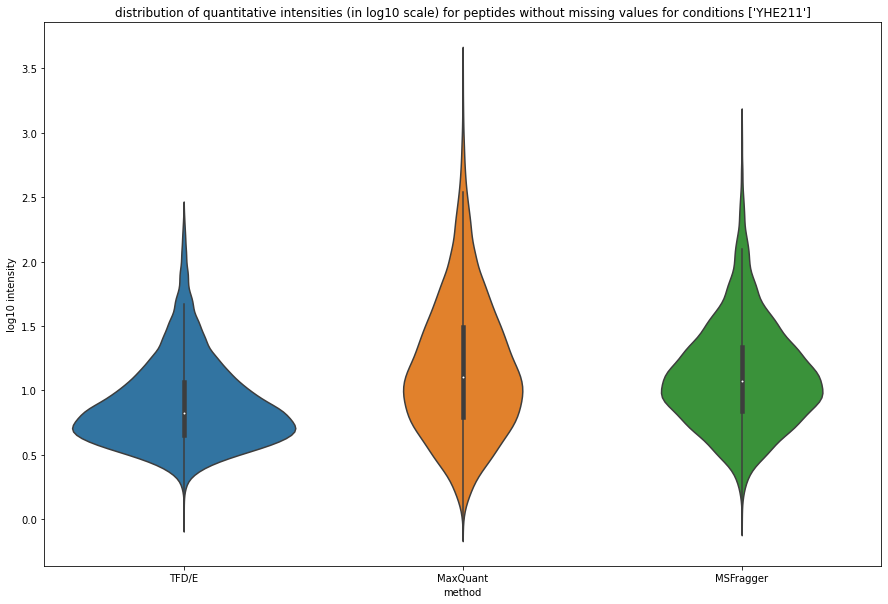

In [107]:
plt.figure(figsize=(15,10))
ax = sns.violinplot(x=intensities_df.method, y=intensities_df.intensity_adjusted_log)
_ = plt.ylabel("log10 intensity")
_ = plt.title('distribution of quantitative intensities (in log10 scale) for peptides without missing values for conditions {}'.format(subset_groups))

In [108]:
# orders of magnitude
intensities_df.groupby('method')['intensity_adjusted_log'].agg(np.ptp)

method
MSFragger    3.064360
MaxQuant     3.496881
TFD/E        2.370584
Name: intensity_adjusted_log, dtype: float64

In [109]:
# number of peptides that have no missing values
intensities_df.groupby('method')['intensity_adjusted_log'].count()

method
MSFragger    11515
MaxQuant      8950
TFD/E        15883
Name: intensity_adjusted_log, dtype: int64

## distribution of CV

#### TFD/E analysis

In [110]:
tfde_subset_df.sample(n=3)

,sequence,charge,id_perc_q_value,protein,species,short_run_name,group,intensity,identified_in_run
12148,ATHPIPAACGIYYFEVK,2,0.000283,"sp|Q6VN20|RBP10_HUMAN,sp|Q96S59|RANB9_HUMAN",Human,YHE211_2,YHE211,612,True
160328,VGDPQELNGITR,2,0.000283,sp|P49327|FAS_HUMAN,Human,YHE211_1,YHE211,855,True
95375,LNTGASIPVLGFGTWR,2,0.000321,sp|Q12458|YPR1_YEAST,Yeast,YHE211_1,YHE211,1544,True


In [111]:
# for each sequence, find the CV
sequence_cv_l = []
for group_name,group_df in tfde_subset_df.groupby(['sequence','charge']):
    if len(group_df) >= 2:
        intensity_cv = np.std(group_df.intensity) / np.mean(group_df.intensity)
        sequence_cv_l.append((group_name[0], group_name[1], intensity_cv))
sequence_cv_df = pd.DataFrame(sequence_cv_l, columns=['sequence','charge','intensity_cv'])

In [112]:
sequence_cv_df.sample(n=3)

,sequence,charge,intensity_cv
15843,TQDQDENVALEACEFWLTLAEQPICK,3,0.413274
14001,SGPLFNFDVHDDVR,2,0.131716
9799,LNEDMACSVAGITSDANVLTNELR,3,0.302198


In [113]:
sequence_cv_df[sequence_cv_df.intensity_cv > 0.25].sample(n=5)

,sequence,charge,intensity_cv
13151,Q[-17.0265]LTDDPIDLFTK,2,0.334282
8006,ISASCQHPTAFEEAIPK,2,0.345994
14288,SLSTTNSSSSSGAPGPCGLAR,2,0.325680
5633,GIEILTDMSRPVELSDR,2,0.345225
7276,IENLEELTNLEELYLSHNFITK,3,0.258295


In [114]:
results_df[(results_df.sequence == 'HVLTGSADNSCR') & (results_df.charge == 2)]

,sequence,charge,identifications,extractions,identifications_d,id_perc_q_value,id_count_all_runs,id_count_human_only_runs,id_number_of_proteins,id_protein,id_species,extractions_l,ext_count_all_runs,ext_count_human_only_runs
7075,HVLTGSADNSCR,2,"{""perc_q_value"": 0.00021431633, ""run_names"": [...","[{""run_name"": ""P3856_YHE211_1_Slot1-1_1_5104"",...","{'perc_q_value': 0.00021431633, 'run_names': [...",0.000214,10,0,1,sp|Q13347|EIF3I_HUMAN,Human,"[{'run_name': 'P3856_YHE211_1_Slot1-1_1_5104',...",10,0
25775,HVLTGSADNSCR,2,"{""perc_q_value"": 1.4979927e-05, ""run_names"": [...","[{""run_name"": ""P3856_YHE114_1_Slot1-1_1_5115"",...","{'perc_q_value': 1.4979927e-05, 'run_names': [...",0.000015,10,0,1,sp|Q13347|EIF3I_HUMAN,Human,"[{'run_name': 'P3856_YHE114_1_Slot1-1_1_5115',...",9,0


In [115]:
tfde_subset_df[(tfde_subset_df.sequence == 'HVLTGSADNSCR') & (tfde_subset_df.charge == 2)]

,sequence,charge,id_perc_q_value,protein,species,short_run_name,group,intensity,identified_in_run
67095,HVLTGSADNSCR,2,0.000214,sp|Q13347|EIF3I_HUMAN,Human,YHE211_1,YHE211,274,True
67096,HVLTGSADNSCR,2,0.000214,sp|Q13347|EIF3I_HUMAN,Human,YHE211_2,YHE211,3244,True
67097,HVLTGSADNSCR,2,0.000214,sp|Q13347|EIF3I_HUMAN,Human,YHE211_3,YHE211,747,True
67098,HVLTGSADNSCR,2,0.000214,sp|Q13347|EIF3I_HUMAN,Human,YHE211_4,YHE211,7638,True
67099,HVLTGSADNSCR,2,0.000214,sp|Q13347|EIF3I_HUMAN,Human,YHE211_5,YHE211,385,True
67100,HVLTGSADNSCR,2,0.000214,sp|Q13347|EIF3I_HUMAN,Human,YHE211_6,YHE211,8309,True
67101,HVLTGSADNSCR,2,0.000214,sp|Q13347|EIF3I_HUMAN,Human,YHE211_7,YHE211,3686,True
67102,HVLTGSADNSCR,2,0.000214,sp|Q13347|EIF3I_HUMAN,Human,YHE211_8,YHE211,675,True
67103,HVLTGSADNSCR,2,0.000214,sp|Q13347|EIF3I_HUMAN,Human,YHE211_9,YHE211,759,True
67104,HVLTGSADNSCR,2,0.000214,sp|Q13347|EIF3I_HUMAN,Human,YHE211_10,YHE211,304,True


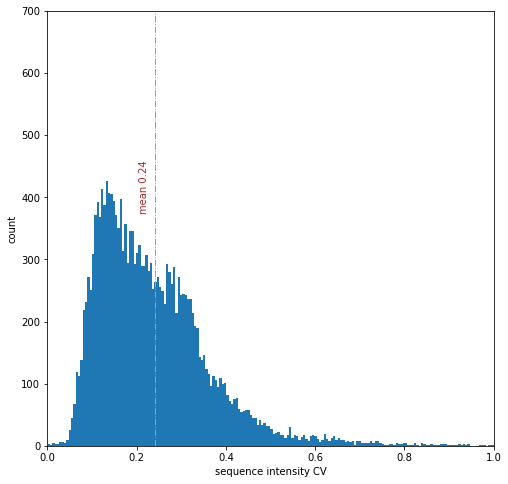

In [116]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(8)

plt.margins(0.06)
plt.title('')

bins = 500
values = sequence_cv_df.intensity_cv
y, x, _ = ax1.hist(values, bins=bins)
mean = np.mean(values)
ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('sequence intensity CV')
plt.ylabel('count')
# plt.title('TFD/E sequence intensity coefficient of variance for conditions {} ({} unique peptides)'.format(subset_groups,len(sequence_cv_df)))
plt.xlim((0,1))
plt.ylim((0,700))

plt.show()

#### MQ analysis

In [117]:
# for each sequence, find the CV
sequence_cv_l = []
for group_name,group_df in mq_subset_df.groupby(['sequence','modifications','charge']):
    if len(group_df) >= 2:
        intensity_cv = np.std(group_df.intensity) / np.mean(group_df.intensity)
        sequence = ','.join([group_name[0],group_name[1],group_name[2].astype('str')])
        sequence_cv_l.append((sequence, intensity_cv))
mq_sequence_cv_df = pd.DataFrame(sequence_cv_l, columns=['sequence','intensity_cv'])

In [118]:
mq_sequence_cv_df.sample(n=3)

,sequence,intensity_cv
7987,"LCQDYDTIGPEGGSLK,Unmodified,2",0.172985
5106,"GFTAAGILSAHK,Unmodified,2",0.186125
5587,"GRYPDHSVDR,Unmodified,2",0.150065


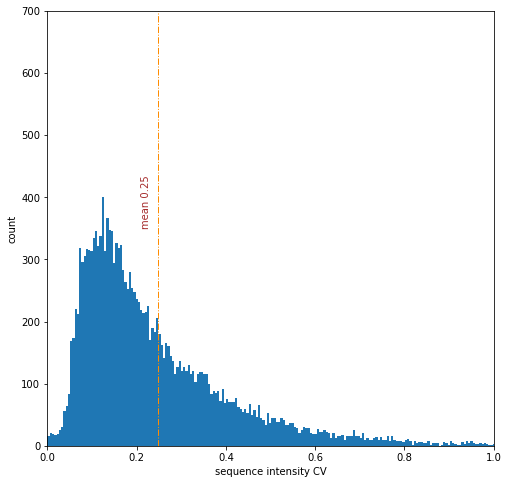

In [119]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(8)

plt.margins(0.06)
plt.title('')

bins = 500
values = mq_sequence_cv_df.intensity_cv
y, x, _ = ax1.hist(values, bins=bins)
mean = np.mean(values)
ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('sequence intensity CV')
plt.ylabel('count')
# plt.title('MaxQuant sequence intensity coefficient of variance for conditions {} ({} unique peptides)'.format(subset_groups, len(mq_sequence_cv_df)))
plt.xlim((0,1))
plt.ylim((0,700))

plt.show()

#### Fragger analysis

In [120]:
# for each sequence, find the CV
sequence_cv_l = []
for group_name,group_df in fragger_subset_df.groupby(['PeptideSequence', 'PrecursorCharge']):
    if len(group_df) >= 2:
        intensity_cv = np.std(group_df.Intensity) / np.mean(group_df.Intensity)
        sequence = ','.join([group_name[0],group_name[1].astype('str')])
        sequence_cv_l.append((sequence, intensity_cv))
fragger_sequence_cv_df = pd.DataFrame(sequence_cv_l, columns=['sequence','intensity_cv'])

In [121]:
fragger_sequence_cv_df.sample(n=3)

,sequence,intensity_cv
9441,"LLEMNLMHAPQVADAILGNQMFTHYDR,3",0.458866
317,"AFDC[57.0215]PETEYPVK,2",0.075738
10992,"MSNYDTDLFVPYFEAIQK,2",0.300870


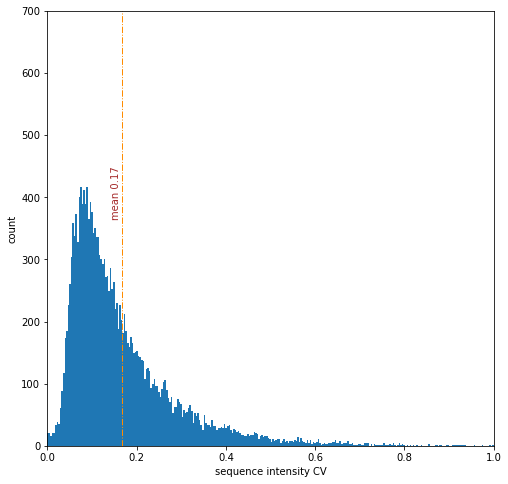

In [122]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(8)

plt.margins(0.06)
plt.title('')

bins = 500
values = fragger_sequence_cv_df.intensity_cv
y, x, _ = ax1.hist(values, bins=bins)
mean = np.mean(values)
ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('sequence intensity CV')
plt.ylabel('count')
# plt.title('MSFragger sequence intensity coefficient of variance for conditions {} ({} unique peptides)'.format(subset_groups,len(fragger_sequence_cv_df)))
plt.xlim((0,1))
plt.ylim((0,700))

plt.show()

## comparison of peptide intensity in different experiment conditions

In [123]:
# the experiment conditions to compare
groupA = 'YHE114'
groupA_number_of_runs = 10
groupB = 'YHE211'
groupB_number_of_runs = 10

#### TFD/E analysis

In [124]:
sequences_df.columns

Index(['sequence', 'charge', 'id_perc_q_value', 'protein', 'species',
       'short_run_name', 'group', 'intensity', 'identified_in_run'],
      dtype='object')

In [125]:
sequences_df.identified_in_run.sum()

220392

In [126]:
len(sequences_df[sequences_df.identified_in_run == True])

220392

In [127]:
# for each sequence and charge, if it was found in more than half the runs, 
# find the mean intensity in each group, then find the intensity ratio between groups
sequence_occurences_in_group = []
for group_name,group_df in sequences_df.groupby(['sequence','charge'], as_index=False):
    sequence_in_A_df = group_df[group_df.group == groupA]
    sequence_in_B_df = group_df[group_df.group == groupB]
    if (
            (sequence_in_A_df.identified_in_run.sum() > 0) and            # must have at least one ID in the group
            (sequence_in_B_df.identified_in_run.sum() > 0) and
            (len(sequence_in_A_df) >= int(groupA_number_of_runs / 2)) and # must have been extracted from more than half the runs in the group
            (len(sequence_in_B_df) >= int(groupB_number_of_runs / 2))
            ):
        intensity_A = sequence_in_A_df.intensity.mean()
        intensity_B = sequence_in_B_df.intensity.mean()
        species = group_df.iloc[0].species
        sequence = group_name[0]
        charge = group_name[1]
        sequence_occurences_in_group.append((sequence, charge, species, intensity_A, intensity_B))

In [128]:
sequence_occurences_in_group_df = pd.DataFrame(sequence_occurences_in_group, columns=['sequence','charge','species','intensity_A','intensity_B'])

In [129]:
sequence_occurences_in_group_df['intensity_ratio'] = sequence_occurences_in_group_df.intensity_B / sequence_occurences_in_group_df.intensity_A

In [130]:
sequence_occurences_in_group_df['intensity_ratio_log'] = np.log2(sequence_occurences_in_group_df['intensity_ratio'])

In [131]:
sequence_occurences_in_group_df[sequence_occurences_in_group_df.intensity_ratio > 4]

,sequence,charge,species,intensity_A,intensity_B,intensity_ratio,intensity_ratio_log
139,ADEALAGLDEGALR,2,Human,353.375000,2665.600000,7.543261,2.915188
145,ADGTGEAQVDNSPTTESNSR,2,Yeast,241.200000,1118.800000,4.638474,2.213650
217,AELRPLQFK,2,Yeast,279.375000,1184.900000,4.241253,2.084490
1036,AVDDFLISLDGTANK,2,Yeast,1038.900000,4821.000000,4.640485,2.214276
1786,DLADELALVDVIEDK,2,Human,484.625000,6444.400000,13.297704,3.733105
2765,EILGTAQSVGCNVDGR,2,Human,820.800000,6348.300000,7.734284,2.951268
3480,FELGEILENDLHDYAK,2,Yeast,229.875000,994.400000,4.325829,2.112977
3935,FTNSETAEHIAQGLR,2,Human,458.200000,1929.300000,4.210607,2.074028
4114,GAVVIDQGAYAALTR,2,Yeast,285.000000,8552.000000,30.007018,4.907228
4358,GHGFEGVTHR,2,Yeast,332.800000,1381.111111,4.149973,2.053102


#### focus on an E.coli peptide that has similar intensity in the two conditions

In [133]:
possible_dup_df = sequence_occurences_in_group_df[(sequence_occurences_in_group_df.intensity_A > 1000) & (np.log2(sequence_occurences_in_group_df.intensity_ratio) > -0.5) & (sequence_occurences_in_group_df.species == 'E. coli')]
possible_dup_df.sample(n=5)

,sequence,charge,species,intensity_A,intensity_B,intensity_ratio,intensity_ratio_log
3622,FIHFMEPLSR,2,E. coli,1097.1,1305.2,1.189682,0.250576
9051,NIFGYQYTIPTHQGR,2,E. coli,6558.2,5386.3,0.821308,-0.284005
6100,IMMNLTTLTHR,2,E. coli,2153.8,2095.2,0.972792,-0.039796
558,ALGGGFPVGALLATEECAR,2,E. coli,1093.6,1173.9,1.073427,0.102224
320,AGDLAAMLTNLEPHDVLFIDEIHR,3,E. coli,1124.8,937.2,0.833215,-0.263240


In [134]:
len(possible_dup_df)

15

In [135]:
seq = 'FIHFMEPLSR'
seq_charge = 2
df_A = sequences_df[(sequences_df.sequence == seq) & (sequences_df.group == groupA)]
df_B = sequences_df[(sequences_df.sequence == seq) & (sequences_df.group == groupB)]

In [136]:
df_A

,sequence,charge,id_perc_q_value,protein,species,short_run_name,group,intensity,identified_in_run
223098,FIHFMEPLSR,2,0.007842,sp|P75712|ALLP_ECOLI,E. coli,YHE114_1,YHE114,1067,True
223099,FIHFMEPLSR,2,0.007842,sp|P75712|ALLP_ECOLI,E. coli,YHE114_2,YHE114,1276,False
223100,FIHFMEPLSR,2,0.007842,sp|P75712|ALLP_ECOLI,E. coli,YHE114_3,YHE114,1095,False
223101,FIHFMEPLSR,2,0.007842,sp|P75712|ALLP_ECOLI,E. coli,YHE114_4,YHE114,1290,False
223102,FIHFMEPLSR,2,0.007842,sp|P75712|ALLP_ECOLI,E. coli,YHE114_5,YHE114,957,False
223103,FIHFMEPLSR,2,0.007842,sp|P75712|ALLP_ECOLI,E. coli,YHE114_6,YHE114,1110,True
223104,FIHFMEPLSR,2,0.007842,sp|P75712|ALLP_ECOLI,E. coli,YHE114_7,YHE114,1129,False
223105,FIHFMEPLSR,2,0.007842,sp|P75712|ALLP_ECOLI,E. coli,YHE114_8,YHE114,861,False
223106,FIHFMEPLSR,2,0.007842,sp|P75712|ALLP_ECOLI,E. coli,YHE114_9,YHE114,1244,False
223107,FIHFMEPLSR,2,0.007842,sp|P75712|ALLP_ECOLI,E. coli,YHE114_10,YHE114,942,True


In [137]:
df_B

,sequence,charge,id_perc_q_value,protein,species,short_run_name,group,intensity,identified_in_run
44888,FIHFMEPLSR,2,0.004969,sp|P75712|ALLP_ECOLI,E. coli,YHE211_1,YHE211,1917,False
44889,FIHFMEPLSR,2,0.004969,sp|P75712|ALLP_ECOLI,E. coli,YHE211_2,YHE211,1029,False
44890,FIHFMEPLSR,2,0.004969,sp|P75712|ALLP_ECOLI,E. coli,YHE211_3,YHE211,1599,False
44891,FIHFMEPLSR,2,0.004969,sp|P75712|ALLP_ECOLI,E. coli,YHE211_4,YHE211,927,False
44892,FIHFMEPLSR,2,0.004969,sp|P75712|ALLP_ECOLI,E. coli,YHE211_5,YHE211,1161,False
44893,FIHFMEPLSR,2,0.004969,sp|P75712|ALLP_ECOLI,E. coli,YHE211_6,YHE211,1758,False
44894,FIHFMEPLSR,2,0.004969,sp|P75712|ALLP_ECOLI,E. coli,YHE211_7,YHE211,1524,False
44895,FIHFMEPLSR,2,0.004969,sp|P75712|ALLP_ECOLI,E. coli,YHE211_8,YHE211,1154,True
44896,FIHFMEPLSR,2,0.004969,sp|P75712|ALLP_ECOLI,E. coli,YHE211_9,YHE211,856,True
44897,FIHFMEPLSR,2,0.004969,sp|P75712|ALLP_ECOLI,E. coli,YHE211_10,YHE211,1127,False


In [138]:
df_A.intensity.mean(), df_A.intensity.std()

(1097.1, 146.179835970781)

In [139]:
df_B.intensity.mean(), df_B.intensity.std()

(1305.2, 366.67145451419526)

In [140]:
sequence_occurences_in_group_df[(sequence_occurences_in_group_df.sequence == seq) & (sequence_occurences_in_group_df.charge == seq_charge)]

,sequence,charge,species,intensity_A,intensity_B,intensity_ratio,intensity_ratio_log
3622,FIHFMEPLSR,2,E. coli,1097.1,1305.2,1.189682,0.250576


#### plot the intensity ratios of the three proteomes

In [146]:
human_df = sequence_occurences_in_group_df[sequence_occurences_in_group_df.species.str.upper() == 'HUMAN']
yeast_df = sequence_occurences_in_group_df[sequence_occurences_in_group_df.species.str.upper() == 'YEAST']
ecoli_df = sequence_occurences_in_group_df[sequence_occurences_in_group_df.species.str.upper() == 'E. COLI']

In [147]:
max_tfde = max(np.log2(sequence_occurences_in_group_df.intensity_A).max(), np.log2(sequence_occurences_in_group_df.intensity_B).max())
min_tfde = min(np.log2(sequence_occurences_in_group_df.intensity_A).min(), np.log2(sequence_occurences_in_group_df.intensity_B).min())
max_tfde, min_tfde

(15.201786992376835, 6.465974464504069)

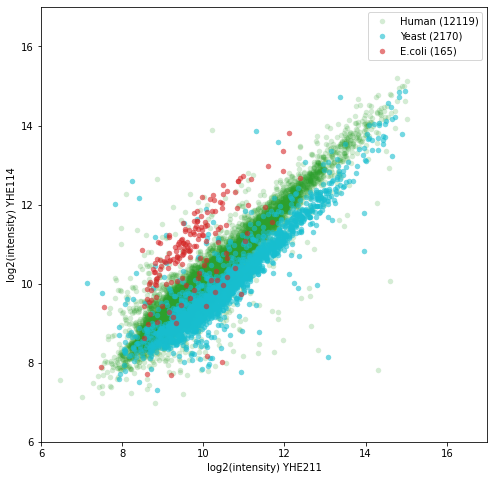

In [148]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(8)
plt.margins(0.06)

# title = 'TFD/E mean intensity of Human, Yeast, and E.coli sequences identified in more than half the technical replicates for {} and {}'.format(groupA, groupB)
# plt.title(title)

ax.scatter(np.log2(human_df.intensity_B), np.log2(human_df.intensity_A), marker='o', color='tab:green', lw=0, s=30, alpha=0.2, label="Human ({})".format(len(human_df)))
ax.scatter(np.log2(yeast_df.intensity_B), np.log2(yeast_df.intensity_A), marker='o', color='tab:cyan', lw=0, s=30, alpha=0.6, label="Yeast ({})".format(len(yeast_df)))
ax.scatter(np.log2(ecoli_df.intensity_B), np.log2(ecoli_df.intensity_A), marker='o', color='tab:red', lw=0, s=30, alpha=0.6, label="E.coli ({})".format(len(ecoli_df)))

plt.legend(loc='best')
plt.xlabel('log2(intensity) {}'.format(groupB))
plt.ylabel('log2(intensity) {}'.format(groupA))

plt.xlim((6,17))
plt.ylim((6,17))

plt.show()

In [149]:
kde_df = sequence_occurences_in_group_df[(sequence_occurences_in_group_df.intensity_ratio <= 3)]

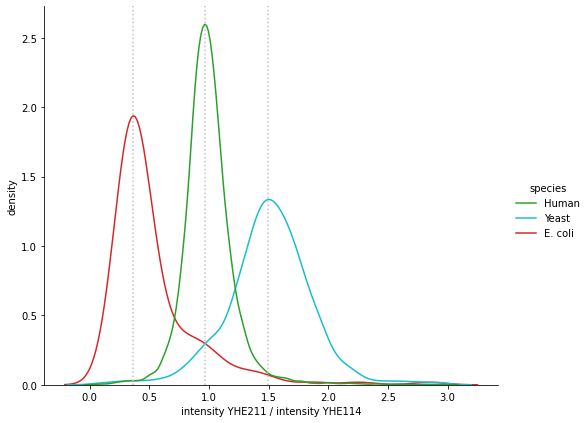

In [150]:
import seaborn as sns

fp = sns.displot(data=kde_df, x=kde_df['intensity_ratio'], hue='species', hue_order=['Human','Yeast','E. coli'], palette=['tab:green','tab:cyan','tab:red'], kind='kde', height=6, aspect=1.2, common_norm=False)

x = fp.ax.lines[0].get_xdata()
y = fp.ax.lines[0].get_ydata()
_ = plt.axvline(x[np.argmax(y)], color='silver', lw=1.5, ls=':')

x = fp.ax.lines[1].get_xdata()
y = fp.ax.lines[1].get_ydata()
_ = plt.axvline(x[np.argmax(y)], color='silver', lw=1.5, ls=':')

x = fp.ax.lines[2].get_xdata()
y = fp.ax.lines[2].get_ydata()
_ = plt.axvline(x[np.argmax(y)], color='silver', lw=1.5, ls=':')


_ = fp.ax.set(xlabel='intensity {} / intensity {}'.format(groupB, groupA), ylabel='density')


#### MQ analysis

In [151]:
mq_sequences_df.columns

Index(['sequence', 'modifications', 'charge', 'species', 'short_run_name',
       'group', 'identified_in_file', 'score', 'intensity'],
      dtype='object')

In [152]:
# for each sequence and charge, if it was found in more than half the runs, 
# find the mean intensity in each group, then find the intensity ratio between groups
sequence_occurences_in_group = []
for group_name,group_df in mq_sequences_df.groupby(['sequence','modifications','charge'], as_index=False):
    sequence_in_A_df = group_df[group_df.group == groupA]
    sequence_in_B_df = group_df[group_df.group == groupB]
    if (len(sequence_in_A_df) >= int(groupA_number_of_runs / 2)) and (len(sequence_in_B_df) >= int(groupB_number_of_runs / 2)):
        average_intensity_in_A = sequence_in_A_df.intensity.mean()
        average_intensity_in_B = sequence_in_B_df.intensity.mean()
        species = group_df.iloc[0].species
        sequence = group_name[0]
        charge = group_name[1]
        sequence_occurences_in_group.append((sequence, charge, species, average_intensity_in_A, average_intensity_in_B))

In [ ]:
mq_sequence_occurences_in_group_df = pd.DataFrame(sequence_occurences_in_group, columns=['sequence','charge','species','intensity_A','intensity_B'])

In [ ]:
mq_sequence_occurences_in_group_df['intensity_ratio'] = mq_sequence_occurences_in_group_df.intensity_B / mq_sequence_occurences_in_group_df.intensity_A

In [ ]:
human_df = mq_sequence_occurences_in_group_df[mq_sequence_occurences_in_group_df.species.upper() == 'HUMAN']
yeast_df = mq_sequence_occurences_in_group_df[mq_sequence_occurences_in_group_df.species.upper() == 'YEAST']
ecoli_df = mq_sequence_occurences_in_group_df[mq_sequence_occurences_in_group_df.species.upper() == 'E.COLI']

In [ ]:
max_mq = max(np.log2(mq_sequence_occurences_in_group_df.intensity_A).max(), np.log2(mq_sequence_occurences_in_group_df.intensity_B).max())
min_mq = min(np.log2(mq_sequence_occurences_in_group_df.intensity_A).min(), np.log2(mq_sequence_occurences_in_group_df.intensity_B).min())
max_mq, min_mq

In [ ]:
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)
plt.margins(0.06)

# title = 'MaxQuant mean intensity of Human, Yeast, and E.coli sequences identified in more than half the technical replicates for {} and {}'.format(groupA, groupB)
# plt.title(title)

ax.scatter(np.log2(human_df.intensity_B), np.log2(human_df.intensity_A), marker='o', color='tab:green', lw=0, s=30, alpha=0.2, label="Human ({})".format(len(human_df)))
ax.scatter(np.log2(ecoli_df.intensity_B), np.log2(ecoli_df.intensity_A), marker='o', color='tab:red', lw=0, s=30, alpha=0.6, label="E.coli ({})".format(len(ecoli_df)))
ax.scatter(np.log2(yeast_df.intensity_B), np.log2(yeast_df.intensity_A), marker='o', color='tab:cyan', lw=0, s=30, alpha=0.6, label="Yeast ({})".format(len(yeast_df)))

plt.legend(loc='best')
plt.xlabel('log2(intensity) {}'.format(groupB))
plt.ylabel('log2(intensity) {}'.format(groupA))

# plt.xlim((7,24))
# plt.ylim((7,24))

plt.show()

In [ ]:
mq_kde_df = mq_sequence_occurences_in_group_df[(mq_sequence_occurences_in_group_df.intensity_ratio <= 3)]

In [ ]:
import seaborn as sns

fp = sns.displot(data=mq_kde_df, x=mq_kde_df['intensity_ratio'], hue='species', hue_order=['Human','Yeast','E. coli'], palette=['tab:green','tab:cyan','tab:red'], kind='kde', height=6, aspect=1.2, common_norm=False)

x = fp.ax.lines[0].get_xdata()
y = fp.ax.lines[0].get_ydata()
_ = plt.axvline(x[np.argmax(y)], color='silver', lw=1.5, ls=':')

x = fp.ax.lines[1].get_xdata()
y = fp.ax.lines[1].get_ydata()
_ = plt.axvline(x[np.argmax(y)], color='silver', lw=1.5, ls=':')

x = fp.ax.lines[2].get_xdata()
y = fp.ax.lines[2].get_ydata()
_ = plt.axvline(x[np.argmax(y)], color='silver', lw=1.5, ls=':')


_ = fp.ax.set(xlabel='intensity {} / intensity {}'.format(groupB, groupA), ylabel='density')

#### Fragger analysis

In [ ]:
fragger_sequences_df.columns

In [ ]:
# for each sequence and charge, if it was found in more than half the runs, 
# find the mean intensity in each group, then find the intensity ratio between groups
sequence_occurences_in_group = []
for group_name,group_df in fragger_sequences_df.groupby(['PeptideSequence','PrecursorCharge'], as_index=False):
    sequence_in_A_df = group_df[group_df.Condition == groupA]
    sequence_in_B_df = group_df[group_df.Condition == groupB]
    if (len(sequence_in_A_df) >= int(groupA_number_of_runs / 2)) and (len(sequence_in_B_df) >= int(groupB_number_of_runs / 2)):
        average_intensity_in_A = sequence_in_A_df.Intensity.mean()
        average_intensity_in_B = sequence_in_B_df.Intensity.mean()
        species = group_df.iloc[0].species
        sequence = group_name[0]
        charge = group_name[1]
        sequence_occurences_in_group.append((sequence, charge, species, average_intensity_in_A, average_intensity_in_B))

In [ ]:
fragger_sequence_occurences_in_group_df = pd.DataFrame(sequence_occurences_in_group, columns=['sequence','charge','species','intensity_A','intensity_B'])

In [ ]:
fragger_sequence_occurences_in_group_df['intensity_ratio'] = fragger_sequence_occurences_in_group_df.intensity_B / fragger_sequence_occurences_in_group_df.intensity_A

In [ ]:
human_df = fragger_sequence_occurences_in_group_df[fragger_sequence_occurences_in_group_df.species.upper() == 'HUMAN']
yeast_df = fragger_sequence_occurences_in_group_df[fragger_sequence_occurences_in_group_df.species.upper() == 'YEAST']
ecoli_df = fragger_sequence_occurences_in_group_df[fragger_sequence_occurences_in_group_df.species.upper() == 'E.COLI']

In [ ]:
max_fragger = max(np.log2(fragger_sequence_occurences_in_group_df.intensity_A).max(), np.log2(fragger_sequence_occurences_in_group_df.intensity_B).max())
min_fragger = min(np.log2(fragger_sequence_occurences_in_group_df.intensity_A).min(), np.log2(fragger_sequence_occurences_in_group_df.intensity_B).min())
max_fragger, min_fragger

In [ ]:
fragger_kde_df = fragger_sequence_occurences_in_group_df[(fragger_sequence_occurences_in_group_df.intensity_ratio <= 3)]

In [ ]:
import seaborn as sns

fp = sns.displot(data=fragger_kde_df, x=fragger_kde_df['intensity_ratio'], hue='species', hue_order=['Human','Yeast','E. coli'], palette=['tab:green','tab:cyan','tab:red'], kind='kde', height=6, aspect=1.2, common_norm=False)

x = fp.ax.lines[0].get_xdata()
y = fp.ax.lines[0].get_ydata()
_ = plt.axvline(x[np.argmax(y)], color='silver', lw=1.5, ls=':')

x = fp.ax.lines[1].get_xdata()
y = fp.ax.lines[1].get_ydata()
_ = plt.axvline(x[np.argmax(y)], color='silver', lw=1.5, ls=':')

x = fp.ax.lines[2].get_xdata()
y = fp.ax.lines[2].get_ydata()
_ = plt.axvline(x[np.argmax(y)], color='silver', lw=1.5, ls=':')


_ = fp.ax.set(xlabel='intensity {} / intensity {}'.format(groupB, groupA), ylabel='density')